In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# GPU 메모리 증가 허용 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 현재 GPU에 대해 메모리 증가 허용 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가 설정을 해야만 합니다
        print('err',e)


In [2]:
# 데이터 디렉토리와 클래스 정의
data_dir = 'C:/Users/oem/Desktop/jhy/new_dataset'  # 데이터가 저장된 폴더 경로
classes = sorted(os.listdir(data_dir))  # 폴더 이름을 기준으로 클래스 리스트 생성
num_classes = len(classes)
print(num_classes, '개의 단어가 저장되어있음')
sequence_length = 30

# 시퀀스 변환 함수
def prepare_sequences_from_array(array, sequence_length=30):
    data = np.asarray(array).astype(np.float16)
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

# 데이터 읽기 함수
def load_data_from_directory(base_dir):
    """폴더 구조를 순회하며 각 클래스별 데이터를 수집합니다."""
    all_data = []
    all_labels = []
    for class_idx, class_name in tqdm(enumerate(classes), total=len(classes)):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.npy'):
                    file_path = os.path.join(class_dir, filename)
                    data = np.load(file_path)  # 데이터 배열 추출
                    sequences = prepare_sequences_from_array(data, sequence_length)
                    all_data.append(sequences)
                    all_labels.extend([class_idx] * len(sequences))  # 각 시퀀스마다 레이블 추가
                    break  # 동일 폴더에 여러 개 포함 시 하나만 취급
    return np.concatenate(all_data), np.array(all_labels)

# 데이터를 메모리로 불러오기
data, labels = load_data_from_directory(data_dir)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 결과 출력
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")



1991 개의 단어가 저장되어있음


100%|██████████| 1991/1991 [00:39<00:00, 50.86it/s]


X_train.shape: (896937, 30, 257)
X_test.shape: (224235, 30, 257)
y_train.shape: (896937,)
y_test.shape: (224235,)


In [3]:
nan_indices_and_labels = []

# X_train에서 NaN 값이 있는 인덱스 추적
for index, sample in enumerate(X_train):
    if np.isnan(sample).any():
        nan_indices_and_labels.append((index, y_train[index]))

# y_train 자체에 NaN이 있는지 확인
for index, label in enumerate(y_train):
    if np.isnan(label):
        nan_indices_and_labels.append((index, label))

# NaN이 포함된 샘플과 레이블 출력
if nan_indices_and_labels:
    print("Samples with NaN values:")
    for index, label in nan_indices_and_labels:
        print(f"Index: {index}, Label: {label}")
else:
    print("No NaN values found in X_train or y_train.")

No NaN values found in X_train or y_train.


In [4]:
len(nan_indices_and_labels)

0

In [5]:
# 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(1024, input_shape=(sequence_length, data.shape[2])), # 30.257
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [6]:
batch_size = 2048
# 제너레이터 함수 정의
def data_generator(X, y, batch_size):
    num_samples = len(X)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

# `output_signature`를 모델의 입력 형태에 맞게 지정
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, y_train, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 30, 257), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int64)
    )
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, y_test, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 30, 257), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int64)
    )
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
import matplotlib.pyplot as plt

# 학습
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)
# fn.noti_print(f'학습 종료됨')

# 모델 요약
model.summary()

Epoch 1/10
438/438 [==============================] - 79s 169ms/step - loss: 0.7573 - accuracy: 0.8925 - val_loss: 0.0347 - val_accuracy: 0.9957
Epoch 2/10
438/438 [==============================] - 73s 167ms/step - loss: 0.0207 - accuracy: 0.9977 - val_loss: 0.0114 - val_accuracy: 0.9987
Epoch 3/10
438/438 [==============================] - 74s 168ms/step - loss: 0.0072 - accuracy: 0.9992 - val_loss: 0.0073 - val_accuracy: 0.9990
Epoch 4/10
438/438 [==============================] - 73s 167ms/step - loss: 0.0046 - accuracy: 0.9995 - val_loss: 0.0051 - val_accuracy: 0.9992
Epoch 5/10
438/438 [==============================] - 73s 168ms/step - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.0043 - val_accuracy: 0.9995
Epoch 6/10
438/438 [==============================] - 73s 167ms/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.0075 - val_accuracy: 0.9989
Epoch 7/10
438/438 [==============================] - 73s 167ms/step - loss: 0.0113 - accuracy: 0.9987 - val_loss: 0.0097 - val_ac

In [8]:
model.save("TEST1991.h5")

In [5]:
# 모델 구성
model = tf.keras.Sequential([
    # 첫 번째 LSTM 레이어
    tf.keras.layers.LSTM(512, return_sequences=True, input_shape=(sequence_length, data.shape[2])),
    tf.keras.layers.Dropout(0.1),
    
    # 두 번째 LSTM 레이어
    tf.keras.layers.LSTM(512),
    tf.keras.layers.Dropout(0.1),
    
    # 세 번째 Dense 레이어
    tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.2),

    # 출력층
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


In [17]:
from filenoti import filenoti as fn #라인 알림

class PrintEpochEndCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fn.noti_print(f'{epoch} 종료됨')

In [6]:
import matplotlib.pyplot as plt

# 학습
history = model.fit(train_dataset, epochs=350, validation_data=test_dataset)
# fn.noti_print(f'학습 종료됨')

# 모델 요약
model.summary()

Epoch 1/350


ValueError: in user code:

    File "c:\Users\oem\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\oem\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\oem\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\oem\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\oem\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\oem\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 30, 257), found shape=(None, 32, 32, 3)


In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 512)           1576960   
                                                                 
 dropout_3 (Dropout)         (None, 30, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1990)             

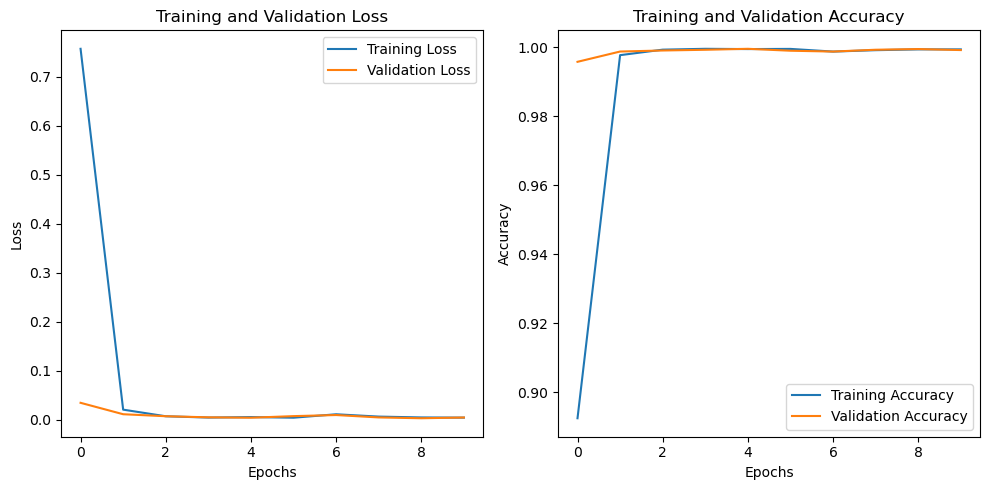

In [9]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy') or history.history.get('acc')  
val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')  

# 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# 정확도 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()